In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import gensim
import re
import nltk
from tqdm import tqdm

from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook
output_notebook()

Loading BokehJS ...

In [26]:
# Import customs module to tokenize and clean tweet dataset
from clean_tokenizer import tokenize_tweets
data_dir = '../input/english_health_tweets.csv'
tweets_df = pd.read_csv(data_dir)
tweets_df.head()

,id,date,timezone,tweet,hashtags,username,name,day,hour,retweet,nlikes,nreplies,nretweets,clean_tweet
0,1244004590699384833,2020-03-28 20:53:01,UTC,"Schlifke said, he and members of the CovidVent...",['#covid19'],KHNews,Kaiser Health News,4,3,False,0,0,1,schlifke say members covidvent coalition help ...
1,1243979929437507585,2020-03-28 19:15:01,UTC,Millions of Americans are seeking care by conn...,"['#covid19', '#telemedicine']",KHNews,Kaiser Health News,6,2,False,6,0,2,millions americans seek care connect doctor el...
2,1243956772123090944,2020-03-28 17:43:00,UTC,We're following the #coronaviruspandemic close...,"['#coronaviruspandemic', '#healthcare', '#heal...",KHNews,Kaiser Health News,5,4,False,0,0,1,follow closely bring best investigation surrou...
3,1243941673270460418,2020-03-28 16:43:00,UTC,About $100 billion of the funding is intended ...,"['#coronavirus', '#relieffunds', '#healthbent']",KHNews,Kaiser Health News,5,12,False,1,0,1,billion fund intend put reimburse eligible hea...
4,1243911473480556544,2020-03-28 14:43:00,UTC,Read KHN's top #COVID19 coverage: The U.S. mil...,['#covid19'],KHNews,Kaiser Health News,6,4,False,4,1,7,read coverage military fly specialize swab ita...


In [34]:
# Convert date to datetime
tweets_df['date'] = pd.to_datetime(tweets_df['date'], errors='coerce')

# Add column for year
tweets_df['year'] = tweets_df['date'].dt.year

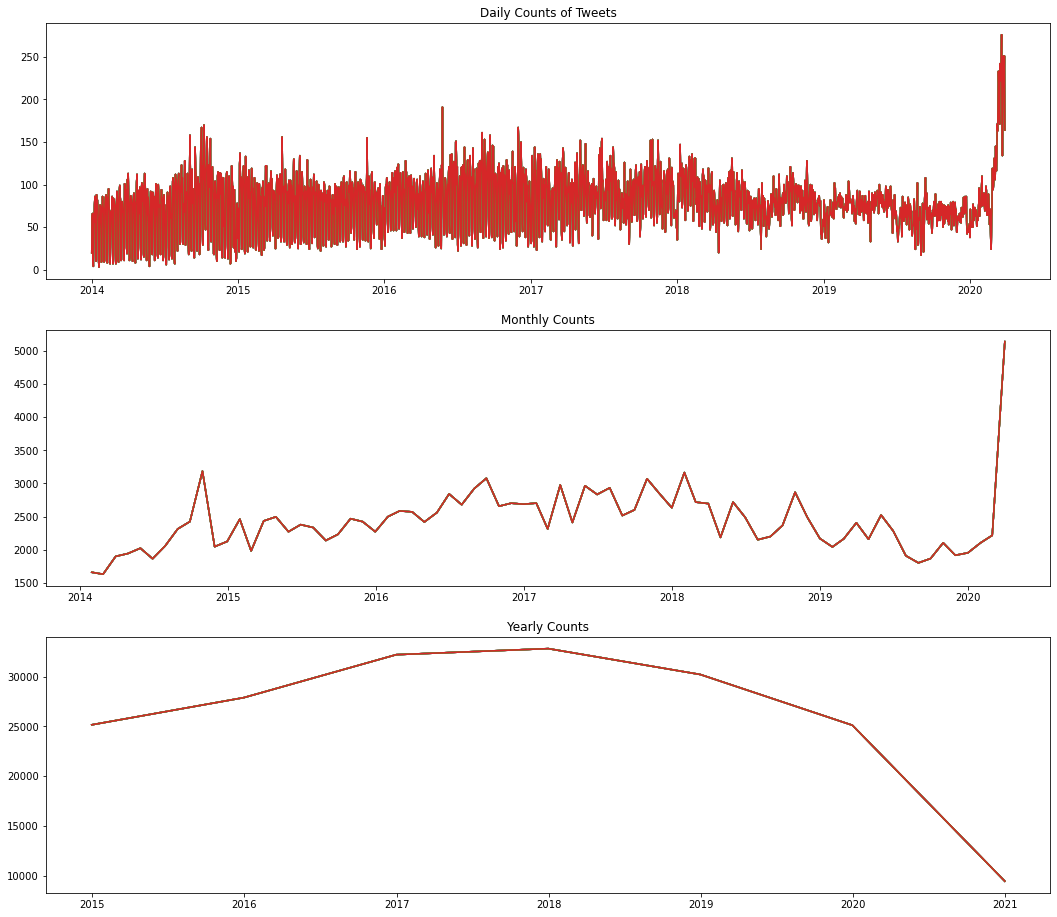

In [35]:
# View tweet density over time

monthly_counts = tweets_df.set_index('date').resample('M').count()
yearly_counts = tweets_df.set_index('date').resample('A').count()
daily_counts = tweets_df.set_index('date').resample('D').count()

fig, ax = plt.subplots(3, figsize=(18,16))
ax[0].plot(daily_counts);
ax[0].set_title('Daily Counts of Tweets');
ax[1].plot(monthly_counts);
ax[1].set_title('Monthly Counts');
ax[2].plot(yearly_counts);
ax[2].set_title('Yearly Counts');
plt.show()

### Gensim Module - LDA Approach

In [36]:
# Create list of each tweets' tokens 
tweets_tokens = tweets_df.clean_tweet.apply(lambda x: re.split('\s', x))

# Create dictionary
dictionary = gensim.corpora.Dictionary(tweets_tokens)

# Test dictionary
count = 0
for k, v in dictionary.iteritems():
    print(k, v)
    count += 1
    if count > 10:
        break


<>:2: DeprecationWarning: invalid escape sequence \s
<>:2: DeprecationWarning: invalid escape sequence \s
<>:2: DeprecationWarning: invalid escape sequence \s
<ipython-input-36-0b25fbd2a94d>:2: DeprecationWarning: invalid escape sequence \s
  tweets_tokens = tweets_df.clean_tweet.apply(lambda x: re.split('\s', x))


0 care
1 center
2 coalition
3 conversion
4 covidvent
5 enable
6 executive
7 federal
8 help
9 hospital
10 members


In [37]:
# Bag of Words
bow_corpus = [dictionary.doc2bow(tweet) for tweet in tweets_tokens]

In [38]:
# Verify BOW is set up correctly
print(tweets_df['clean_tweet'].sample(n=1, random_state=0))
print(bow_corpus[8336])

bow_tweet_8336 = bow_corpus[8336]
for i in range(len(bow_tweet_8336)):
    print("Word {} (\"{}\") appears {} time.".format(bow_tweet_8336[i][0], 
                                               dictionary[bow_tweet_8336[i][0]], 
bow_tweet_8336[i][1]))

61175    president bush tout signature africa aid progr...
Name: clean_tweet, dtype: object
[(2260, 1), (2923, 1), (3604, 1), (4920, 1), (7377, 1)]
Word 2260 ("interact") appears 1 time.
Word 2923 ("repeal") appears 1 time.
Word 3604 ("legislators") appears 1 time.
Word 4920 ("obamacare") appears 1 time.
Word 7377 ("constituents") appears 1 time.


#### Determining best number of topics

In [10]:
import pyLDAvis.gensim
from gensim import models
from gensim.models.coherencemodel import CoherenceModel


In [39]:
# Create list of cleaned tweets
tweets_list =  tweets_df['clean_tweet']

In [1]:
%%time

# Iterate through range of k-topics fitting LDA model to each and computing coherence scores for each model
coherenceList_umass = []
coherenceList_cv = []
num_topics_list = np.arange(4,14+1)
for num_topics in tqdm(num_topics_list):
    lda = models.LdaMulticore(corpus=bow_corpus, num_topics=num_topics, id2word=dictionary, 
                              passes=10,chunksize=4000,random_state=0)
    cm = CoherenceModel(model=lda, corpus=bow_corpus, 
                        dictionary=filtered_dict, coherence='u_mass')
    coherenceList_umass.append(cm.get_coherence())
    viz = pyLDAvis.gensim.prepare(lda, bow_corpus, filtered_dict)
    pyLDAvis.save_html(viz,f'pyLDAvis_{num_topics}.html')

Text(0.5, 1.0, 'Topic Coherence')

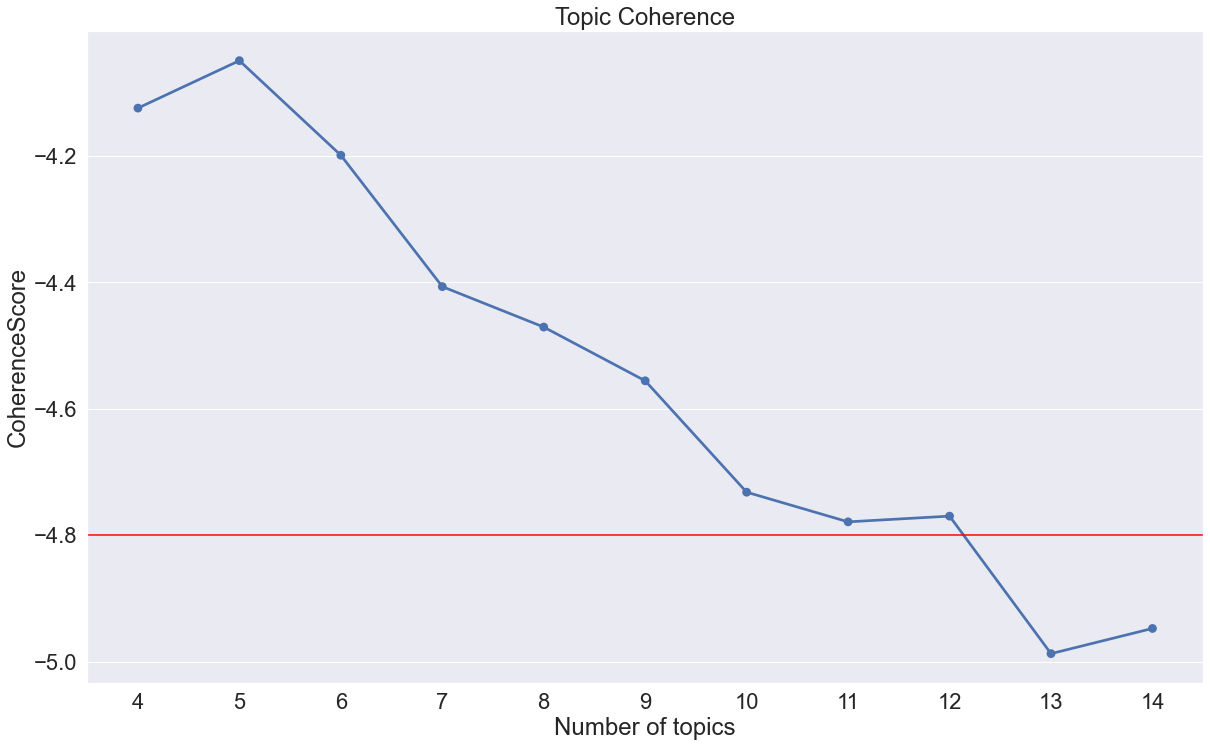

In [188]:
# Plot coherence scores across topic numbers

plotData = pd.DataFrame({'Number of topics':num_topics_list,
                         'CoherenceScore':coherenceList_umass})
f,ax = plt.subplots(figsize=(16,10))
sns.set_style("darkgrid")
sns.set(font_scale = 2)
sns.pointplot(x='Number of topics', y= 'CoherenceScore',data=plotData)
plt.axhline(y=-4.8, color='red')
plt.title('Topic Coherence')

__LDA Modeling Using 10 Topics__

In [40]:
%%time
# LDA Model using BOW
lda_model_bow = gensim.models.LdaMulticore(corpus=bow_corpus, num_topics=10, id2word=dictionary, decay=0.5,
                                           chunksize=10000, passes=10, workers=4, random_state=0)

Wall time: 4min 35s


In [41]:
topic_desc = []
for idx, topic in lda_model_bow.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.053*"health" + 0.030*"care" + 0.014*"drug" + 0.013*"plan" + 0.011*"say" + 0.011*"trump" + 0.009*"state" + 0.008*"obamacare" + 0.008*"company" + 0.008*"price"
Topic: 1 
Words: 0.057*"cancer" + 0.031*"drug" + 0.020*"study" + 0.019*"risk" + 0.015*"breast" + 0.014*"diet" + 0.014*"weight" + 0.012*"treatment" + 0.012*"women" + 0.010*"lose"
Topic: 2 
Words: 0.023*"test" + 0.015*"birth" + 0.014*"patients" + 0.013*"ask" + 0.012*"blood" + 0.011*"control" + 0.010*"short" + 0.010*"need" + 0.010*"doctor" + 0.009*"home"
Topic: 3 
Words: 0.020*"live" + 0.018*"save" + 0.013*"nurse" + 0.013*"life" + 0.010*"die" + 0.010*"free" + 0.010*"world" + 0.010*"time" + 0.010*"week" + 0.010*"healthcare"
Topic: 4 
Words: 0.022*"study" + 0.017*"children" + 0.014*"parent" + 0.014*"find" + 0.013*"kid" + 0.013*"food" + 0.010*"drink" + 0.008*"brain" + 0.007*"say" + 0.007*"people"
Topic: 5 
Words: 0.044*"ebola" + 0.039*"doctor" + 0.021*"hospital" + 0.018*"patient" + 0.009*"patients" + 0.009*"miss" + 0.

In [42]:
%%time
import pyLDAvis
import pyLDAvis.gensim 

# LDA Visualization Tool
lda_viz = pyLDAvis.gensim.prepare(lda_model_bow, bow_corpus, dictionary, mds='tsne')

Wall time: 3min 35s


In [43]:
pyLDAvis.enable_notebook()
lda_viz

PreparedData(topic_coordinates=               x          y  topics  cluster       Freq
topic                                                  
0      32.420952   8.115230       1        1  15.371948
7       0.648955  71.707100       2        1  11.590927
1      71.019684   9.971006       3        1  10.786427
8       3.785981  33.185135       4        1  10.363234
4     -42.666500  -9.222070       5        1   9.997335
3      -3.621689 -43.526516       6        1   9.325179
9      -3.632402  -4.171708       7        1   8.311174
5     -36.584400  35.804413       8        1   8.145414
2      44.391380  50.615383       9        1   8.136957
6      40.235809 -31.591665      10        1   7.971399, topic_info=        Term         Freq         Total Category  logprob  loglift
2580  cancer  8239.000000   8239.000000  Default  30.0000  30.0000
6959   ebola  4797.000000   4797.000000  Default  29.0000  29.0000
8       help  6890.000000   6890.000000  Default  28.0000  28.0000
67      know  4445.000000   4445.000000  Default  27.0000  27.0000
0       care  6364.000000   6364.000000  Default  26.0000  26.0000
...      ...          ...           ...      ...      ...      ...
786     live   462.830963   3896.692871  Topic10  -5.3749   0.3988
19    doctor   501.818970   7537.039062  Topic10  -5.2941  -0.1800
70      want   421.371399   2444.138916  Topic10  -5.4688   0.7714
79      need   434.137634   4085.864014  Topic10  -5.4389   0.2874
13       say   441.768433  10215.458008  Topic10  -5.4215  -0.6116

[789 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
7166      3  0.988168    abbvie
7969      4  0.990776      acid
72        1  0.015477  actually
72        2  0.775133  actually
72        3  0.091571  actually
...     ...       ...       ...
9144      1  0.000476      zika
9144      4  0.961623      zika
9144      7  0.005715      zika
9144      9  0.029054      zika
9144     10  0.002858      zika

[2419 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 8, 2, 9, 5, 4, 10, 6, 3, 7])

### SK-Learn Module - LDA Package Approach

In [44]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from collections import Counter

In [45]:
count_vectorizer = CountVectorizer(stop_words='english', max_features=40000)
tweet_text = tweets_df['clean_tweet'].values

print('Tweet before vectorization: {}'.format(tweet_text[4321]))
document_term_matrix = count_vectorizer.fit_transform(tweet_text)

# Verify vectorization
print('Tweet after vectorization: \n{}'.format(document_term_matrix[4321]))

Tweet before vectorization: albert bourla chief executive officer pfizer time serve group president pfizer innovative health
Tweet after vectorization: 
  (0, 8025)	1
  (0, 23945)	1
  (0, 10528)	1
  (0, 10045)	1
  (0, 18500)	1
  (0, 4063)	1
  (0, 16507)	1
  (0, 21253)	1
  (0, 11836)	1
  (0, 579)	1
  (0, 2786)	1
  (0, 17719)	2


In [46]:
%%time
# Define target number of topics
n_topics = 10

# Fit model
lda_model = LatentDirichletAllocation(n_components=n_topics, learning_method='online', batch_size=10000, 
                                          random_state=0, learning_decay=0.5, verbose=0)
# Create topic matrix
lda_topic_matrix = lda_model.fit_transform(document_term_matrix)

Wall time: 11min 22s


In [50]:
# Define helper functions
def get_keys(topic_matrix):
    '''
    returns an integer list of predicted topic 
    categories for a given topic matrix
    '''
    keys = topic_matrix.argmax(axis=1).tolist()
    return keys

def keys_to_counts(keys):
    '''
    returns a tuple of topic categories and their 
    accompanying magnitudes for a given list of keys
    '''
    count_pairs = Counter(keys).items()
    categories = [pair[0] for pair in count_pairs]
    counts = [pair[1] for pair in count_pairs]
    return (categories, counts)

In [51]:
lda_keys = get_keys(lda_topic_matrix)
lda_categories, lda_counts = keys_to_counts(lda_keys)

In [52]:
# Define helper function
def get_top_n_words(n, keys, document_term_matrix, count_vectorizer):
    '''
    returns a list of n_topic strings, where each string contains the n most common 
    words in a predicted category, in order
    '''
    top_word_indices = []
    for topic in range(n_topics):
        temp_vector_sum = 0
        for i in range(len(keys)):
            if keys[i] == topic:
                temp_vector_sum += document_term_matrix[i]
        temp_vector_sum = temp_vector_sum.toarray()
        top_n_word_indices = np.flip(np.argsort(temp_vector_sum)[0][-n:],0)
        top_word_indices.append(top_n_word_indices)   
    top_words = []
    for topic in top_word_indices:
        topic_words = []
        for index in topic:
            temp_word_vector = np.zeros((1,document_term_matrix.shape[1]))
            temp_word_vector[:,index] = 1
            the_word = count_vectorizer.inverse_transform(temp_word_vector)[0][0]
            topic_words.append(the_word.encode('ascii').decode('utf-8'))
        top_words.append(" ".join(topic_words))         
    return top_words

In [53]:
%%time 
# Display top 10 words for each topic
top_n_words_lda = get_top_n_words(10, lda_keys, document_term_matrix, count_vectorizer) 
for i in range(len(top_n_words_lda)):
    print("Topic {}: ".format(i+1), top_n_words_lda[i])

Topic 1:  heart baby disease brain help parent blood study doctor people
Topic 2:  health drug say plan obamacare trump year state cost insurance
Topic 3:  help like exercise diet healthy foods opioid ways drug work
Topic 4:  drink food sleep say kid help time tip study healthy
Topic 5:  ebola coronavirus case outbreak say health doctor test china ask
Topic 6:  weight zika virus lose say spread loss diet health kill
Topic 7:  doctor drug patients medical say health nurse hospital hospitals state
Topic 8:  risk study know help people need say pain test women
Topic 9:  health care mental doctor news change healthcare today patients need
Topic 10:  cancer drug study breast live patients treatment help say save
Wall time: 2min 2s


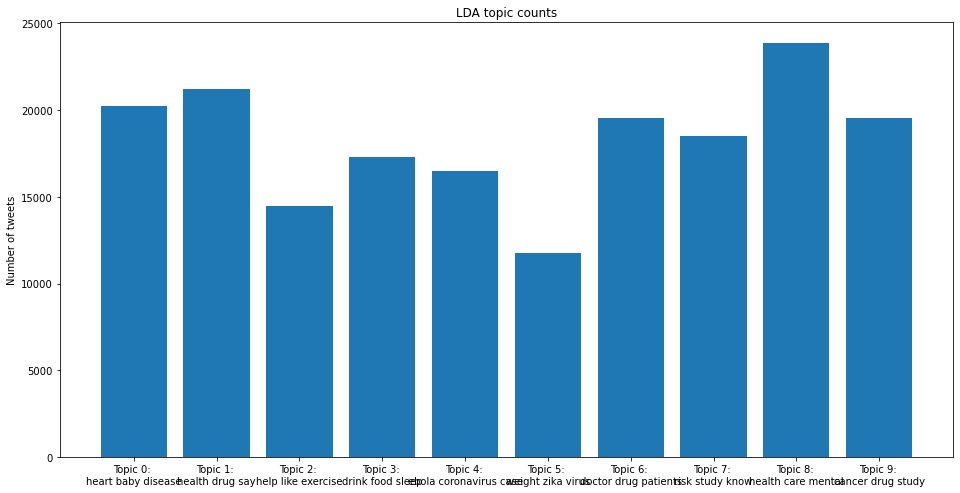

In [54]:
# Plot tweet counts by topics
top_3_words = get_top_n_words(3, lda_keys, document_term_matrix, count_vectorizer) 
labels = ['Topic {}: \n'.format(i) + top_3_words[i] for i in lda_categories]

fig, ax = plt.subplots(figsize=(16,8))
ax.bar(lda_categories, lda_counts);
ax.set_xticks(lda_categories);
ax.set_xticklabels(labels);
ax.set_title('LDA topic counts');
ax.set_ylabel('Number of tweets');

In [64]:
# Sample documents from lda topic matrix for t-SNE use
np.random.seed(0)
indices = np.random.choice(len(lda_topic_matrix)-1, 10000, replace=False)
lda_topic_matrix_sample =  lda_topic_matrix[indices]

In [65]:
%%time
# Apply dimensionality reduction using t-SNE
from sklearn.manifold import TSNE
tsne_lda_model = TSNE(n_components=2, perplexity=50, learning_rate=100, 
                        n_iter=1000, verbose=1, random_state=0, angle=0.75)
tsne_lda_vectors = tsne_lda_model.fit_transform(lda_topic_matrix_sample) 


[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.049s...
[t-SNE] Computed neighbors for 10000 samples in 4.213s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.090180
[t-SNE] KL divergence after 250 iterations with early exaggeration: 86.075256
[t-SNE] KL divergence after 1000 iterations: 1.518019
Wall time: 1min 59s


In [60]:
# Define helper functions
def get_mean_topic_vectors(keys, two_dim_vectors):
    '''
    returns a list of centroid vectors from each predicted topic category
    '''
    mean_topic_vectors = []
    for t in range(n_topics):
        articles_in_that_topic = []
        for i in range(len(keys)):
            if keys[i] == t:
                articles_in_that_topic.append(two_dim_vectors[i])    
        articles_in_that_topic = np.vstack(articles_in_that_topic)
        mean_article_in_that_topic = np.mean(articles_in_that_topic, axis=0)
        mean_topic_vectors.append(mean_article_in_that_topic)
    return mean_topic_vectors

In [61]:
# Define color-map for clustering visualization plot
colormap = np.array([
    "#1f77b4", "#aec7e8", "#ff7f0e", "#ffbb78", "#2ca02c",
    "#98df8a", "#d62728", "#ff9896", "#9467bd", "#c5b0d5",
    "#8c564b", "#c49c94", "#e377c2", "#f7b6d2", "#7f7f7f",
    "#c7c7c7", "#bcbd22", "#dbdb8d", "#17becf", "#9edae5" ])
colormap = colormap[:n_topics]

In [66]:
# Rerun generating lda keys to account for the new sample being used in t-SNE (10k records)
lda_keys_sample = get_keys(lda_topic_matrix_sample)

In [67]:
%%time 
# Plot t-SNE clustering results
top_3_words_lda = get_top_n_words(3, lda_keys, document_term_matrix, count_vectorizer)
lda_mean_topic_vectors = get_mean_topic_vectors(lda_keys_sample, tsne_lda_vectors) 

plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), plot_width=700, plot_height=700)
plot.scatter(x=tsne_lda_vectors[:,0], y=tsne_lda_vectors[:,1], color=colormap[lda_keys_sample])

for t in range(n_topics):
    label = Label(x=lda_mean_topic_vectors[t][0], y=lda_mean_topic_vectors[t][1], 
                  text=top_3_words_lda[t], text_color=colormap[t])
    plot.add_layout(label)

show(plot)

Wall time: 2min 1s


### Heat Map Visualizations by Year/User

In [69]:
# Re-index dataframe by user(news source)
reindexed_tweets = tweets_df['clean_tweet']
reindexed_tweets.index = tweets_df['username']

In [70]:
%%time

# Generate counts of tweets per topic across each news source
news_sources = tweets_df['username'].unique()

user_data = []
for source in news_sources:
    user_data.append(reindexed_tweets[source].values)

user_topic_matrices = []
for user in user_data:
    document_term_matrix = count_vectorizer.transform(user)
    topic_matrix = lda_model.transform(document_term_matrix)
    user_topic_matrices.append(topic_matrix)

user_keys = []
for topic_matrix in user_topic_matrices:
    user_keys.append(get_keys(topic_matrix))
    
user_counts = []
for keys in user_keys:
    categories, counts = keys_to_counts(keys)
    user_counts.append(counts)

user_topic_counts = pd.DataFrame(np.array(user_counts), index=news_sources)
user_topic_counts.columns = ['Topic {}'.format(i+1) for i in range(n_topics)]
user_topic_counts

Wall time: 41.5 s


,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,Topic 10
KHNews,1705,859,2934,3162,572,562,648,506,474,627
NPRHealth,1078,1436,1551,1437,926,1014,1852,948,798,959
USNewsHealth,1971,1681,2056,2203,821,1395,522,862,578,1855
latimeshealth,439,423,633,407,444,371,418,563,411,398
HarvardHealth,1466,222,829,263,776,1303,1016,838,327,245
WSJhealth,414,121,124,531,281,213,103,273,106,159
Reuters_Health,1052,2888,3004,2986,908,2569,913,1665,1313,1047
NBCNewsHealth,1121,1183,1706,1497,1103,1738,1270,1362,1317,915
bbchealth,733,831,1247,912,1229,1195,768,1172,465,590
foxnewshealth,2829,3283,1607,1482,1762,1319,2134,1088,2425,1504


In [71]:
# Add column to sum total topics 
user_topic_counts['total_topics'] =  user_topic_counts.sum(axis=1)

# Convert topic counts to percentages for each news source 
user_topic_counts_ratio =  user_topic_counts.apply(lambda x: (x / user_topic_counts['total_topics']))
user_topic_counts_ratio = user_topic_counts_ratio.drop(columns=['total_topics'])
user_topic_counts_ratio

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,Topic 10
KHNews,0.141506,0.071292,0.243506,0.262428,0.047473,0.046643,0.053780,0.041995,0.039339,0.052038
NPRHealth,0.089841,0.119677,0.129261,0.119760,0.077173,0.084507,0.154346,0.079007,0.066506,0.079923
USNewsHealth,0.141351,0.120554,0.147447,0.157989,0.058878,0.100043,0.037435,0.061819,0.041452,0.133032
latimeshealth,0.097404,0.093854,0.140448,0.090304,0.098513,0.082316,0.092745,0.124917,0.091191,0.088307
HarvardHealth,0.201235,0.030474,0.113795,0.036102,0.106520,0.178861,0.139465,0.115031,0.044887,0.033631
WSJhealth,0.178065,0.052043,0.053333,0.228387,0.120860,0.091613,0.044301,0.117419,0.045591,0.068387
Reuters_Health,0.057345,0.157427,0.163750,0.162769,0.049496,0.140038,0.049768,0.090760,0.071573,0.057073
NBCNewsHealth,0.084847,0.089540,0.129125,0.113306,0.083485,0.131547,0.096125,0.103088,0.099682,0.069255
bbchealth,0.080179,0.090899,0.136403,0.099759,0.134434,0.130715,0.084008,0.128200,0.050864,0.064537
foxnewshealth,0.145577,0.168939,0.082694,0.076262,0.090671,0.067874,0.109813,0.055987,0.124788,0.077394


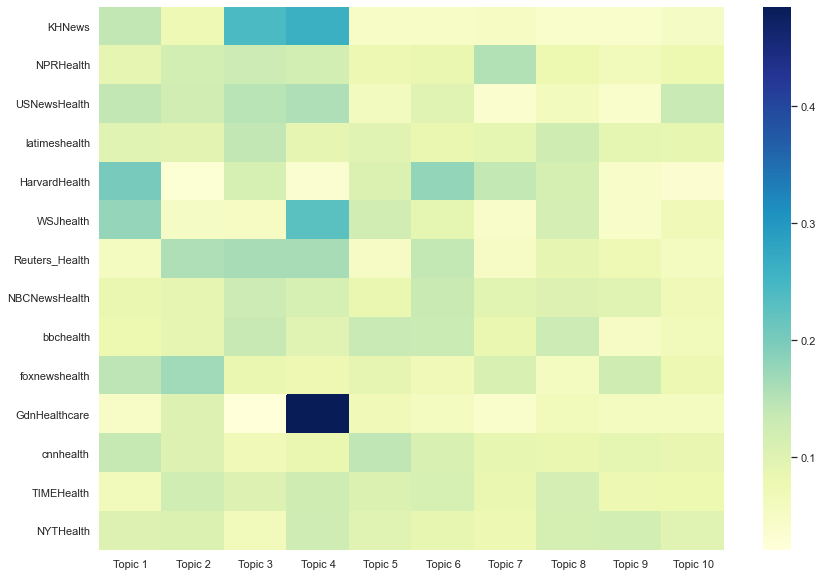

In [83]:
# Display heat map of topics vs news sources
fig, ax = plt.subplots(figsize=(14,10))
sns.set(font_scale=1)
sns.heatmap(user_topic_counts_ratio, cmap="YlGnBu", ax=ax);
plt.show()

In [2]:
# Re-index dataframe by year
reindexed_tweets = tweets_df['clean_tweet']
reindexed_tweets.index = tweets_df['year']

In [85]:
%%time

# Generate counts of tweets per topic across years
yearly_data = []
for i in range(2014,2020+1):
    yearly_data.append(reindexed_tweets[i].values)

yearly_topic_matrices = []
for year in yearly_data:
    document_term_matrix = count_vectorizer.transform(year)
    topic_matrix = lda_model.transform(document_term_matrix)
    yearly_topic_matrices.append(topic_matrix)

yearly_keys = []
for topic_matrix in yearly_topic_matrices:
    yearly_keys.append(get_keys(topic_matrix))
    
yearly_counts = []
for keys in yearly_keys:
    categories, counts = keys_to_counts(keys)
    yearly_counts.append(counts)

yearly_topic_counts = pd.DataFrame(np.array(yearly_counts), index=range(2014,2020+1))
yearly_topic_counts.columns = ['Topic {}'.format(i+1) for i in range(n_topics)]

yearly_topic_counts

Wall time: 40.9 s


,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,Topic 10
2014,2219,2939,2861,1796,2645,2494,2187,1540,2534,3944
2015,4502,2553,1725,2684,3141,2486,3105,2867,2828,1995
2016,3213,3258,3786,2495,3430,3515,2084,3434,2656,4329
2017,3632,4808,3470,2056,2003,3014,3019,3656,4664,2486
2018,1985,3637,3546,3441,3420,3107,2349,2776,3564,2385
2019,2271,3093,2490,2152,2909,3218,2766,3186,1431,1601
2020,966,756,1135,1074,496,489,788,602,2478,677


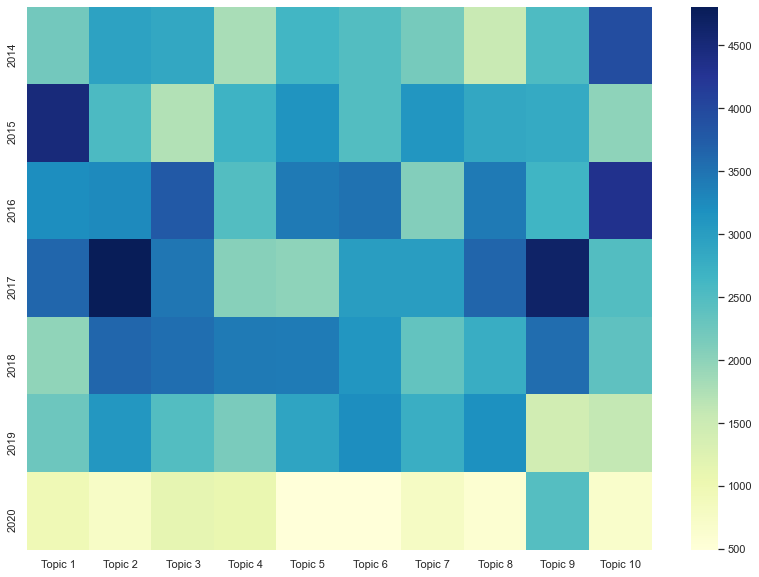

In [87]:
# Display heat map of topics vs years
fig, ax = plt.subplots(figsize=(14,10))
sns.heatmap(yearly_topic_counts, cmap="YlGnBu", ax=ax);
plt.show()